In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import load_breast_cancer
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Normalizer
from matplotlib.colors import ListedColormap
import seaborn as sns

data = load_breast_cancer()

In [69]:
print("The sklearn breast cancer dataset keys:")
print(data.keys()) # dict_keys(['target_names', 'target', 'feature_names', 'dataa', 'DESCR'])
print("---")

li_classes = [data.target_names[1], data.target_names[0]]
li_target = [1 if x==0 else 0 for x in list(data.target)]
features = list(data.feature_names)

print("There are 2 target classes:")
print("li_classes", li_classes)
print("---")
print("Target class distribution from a total of %d target values:" % len(li_target))
print(pd.Series(li_target).value_counts())
print("---")
print("Number and name of features : ")
print(len(features), features)
print("---")


df_all = pd.DataFrame(data.data[:,:], columns=features)
print("Describe dataframe, first 6 columns:")
print(df_all.iloc[:,:6].describe().to_string())

The sklearn breast cancer dataset keys:
dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])
---
There are 2 target classes:
li_classes ['benign', 'malignant']
---
Target class distribution from a total of 569 target values:
0    357
1    212
dtype: int64
---
Number and name of features : 
30 ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']
---
Describe dataframe, first 6 columns:
       mean radius  mean texture  

In [70]:
print(df_all.shape)
labels = np.reshape(data.target,(len(data.target),1))
df_all = np.concatenate([df_all,labels],axis=1)
print(df_all.shape)

li_ftrs = features.copy()
li_ftrs.insert(len(li_ftrs),"Labels")

(569, 30)
(569, 31)


In [71]:
DB = pd.DataFrame(df_all,columns=li_ftrs)
DB

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Labels
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0.0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0.0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0.0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0.0


In [72]:
def pca(X,pc):
    ''' Principal Component Regression '''
    # Define the PCA object
    pca = PCA(n_components=pc, svd_solver='full')
    # Preprocess/ Standardize features by removing the mean and scaling to unit variance
    Xstd = StandardScaler().fit_transform(X)
    # Run PCA producing the reduced variable Xred
    Xred = pca.fit_transform(Xstd)[:,:pc]
    
    #print (pca.explained_variance_)
    #print (pca.explained_variance_ratio_)
    return(pca.explained_variance_ratio_.sum())
    
def pcr(X,pc, y):
    # Define the PCA object
    pca = PCA(n_components=pc, svd_solver='full')
    # Preprocess/ Standardize features by removing the mean and scaling to unit variance
    Xstd = StandardScaler().fit_transform(X)
    # Run PCA producing the reduced variable Xred
    Xred = pca.fit_transform(Xstd)[:,:pc]

    ''' Step 2: regression on selected principal components'''
    # Create linear regression object
    regr = linear_model.LinearRegression()
    # Fit
    regr.fit(Xred, y)
    # Predictions
    y_c = regr.predict(Xred)
    # Calculate R2 scores
    score_c = r2_score(y, y_c)
    # Calculate mean square error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    return(score_c, mse_c)

#### Normalizing the data

In [89]:
X = DB.loc[:, features].values
y = DB.loc[:, "Labels"].values

transfo = Normalizer().fit(X)
X = transfo.transform(X)

In [90]:
var_explained = []
r_sq = []
mse = []
for pc in range(1,10):
    var_explained.append(pca(X,pc))
    r_sq.append(pcr(X,pc,y)[0])
    mse.append(pcr(X,pc,y)[1])



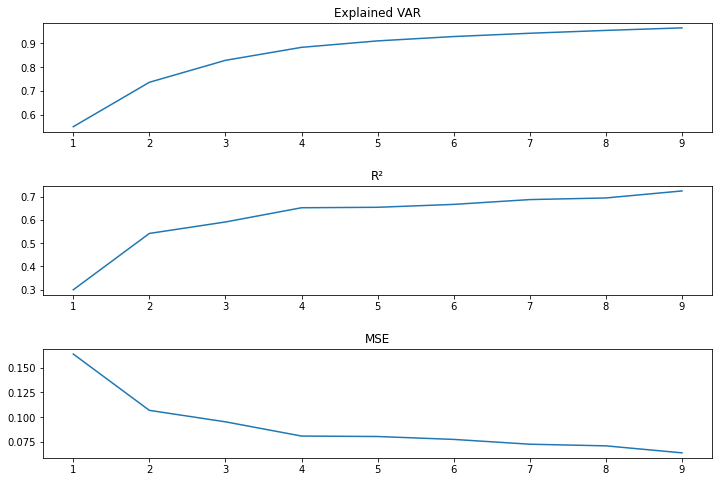

In [91]:
fig, axs = plt.subplots(3, sharex=False, sharey=False, figsize = (12,8), gridspec_kw={"hspace" : .5})
tmp = axs[0].plot(range(1,10),var_explained)

tmp = axs[1].plot(range(1,10),r_sq)

tmp = axs[2].plot(range(1,10),mse)
_ = axs[0].set_title('Explained VAR')
_ = axs[1].set_title('R²')
_ = axs[2].set_title('MSE')

Text(0.5, 1.0, 'KMeans clustering plot')

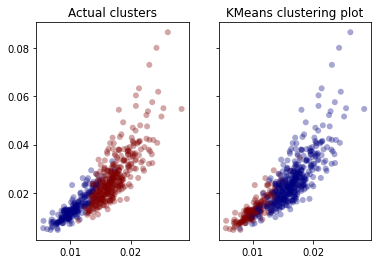

In [92]:
#1 KMeans Clustering >> k=2 i.e. either Malignant or Benign
km = KMeans(n_clusters=2, init="k-means++", n_init=10)
km_pred = km.fit_predict(X)

# Scatter plots
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(X[:,0], X[:,1], c=y, cmap="jet", edgecolor="None", alpha=0.35)
ax1.set_title("Actual clusters")

ax2.scatter(X[:,0], X[:,1], c=km_pred, cmap="jet", edgecolor="None", alpha=0.35)
ax2.set_title("KMeans clustering plot")

### KNN Classification

First do a PCA to have the two best 2 representative axis. This is for comparision purpose.

In [93]:
def PCA_projector(n_axis, X):
    pca = PCA(n_components=n_axis)
    X_transformed = pca.fit_transform(X)
    return X_transformed

In [94]:
X = PCA_projector(2, X)

In [95]:
number_of_knns = [1, 6, 10, 50]

In [96]:
def knn_creator(number_of_knns, X, y):
    num_model = len(number_of_knns)
    models = []
    for i in range(num_model):
        mod = KNeighborsClassifier(n_neighbors=number_of_knns[i])
        mod.fit(X, y)
        models.append(mod)
    return models



In [97]:
models_knn = knn_creator(number_of_knns, X, y)

In [98]:
models_knn[0].get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 1,
 'p': 2,
 'weights': 'uniform'}

In [121]:
cmap_light = ListedColormap(['orange', 'cyan'])
cmap_bold = ['darkorange', 'c']

def plot_decision_boundary(X, y, models, per_row=4, **kwargs):
    n_models = len(models)
    n_row_plot = 2#(n_models/per_row)
    
    fig, axs = plt.subplots(n_row_plot, per_row, **kwargs)
    X1, X2 = np.meshgrid(
        np.arange(start = X[:,0].min()-1, stop = X[:,0].max() + 1, step = .02),
        np.arange(start = X[:,1].min()-1, stop = X[:,1].max() + 1, step = .02),
    )
    for i, model in enumerate(models):
        ax = axs[i//per_row, i%per_row]
        Z = model.predict(np.c_[X1.ravel(), X2.ravel()])
    
        Z = Z.reshape(X1.shape)
        ax.contourf(X1, X2, Z, cmap=cmap_light)
    
        sns.scatterplot(x=X[:, 0], y=X[:, 1],
                    palette=cmap_bold, alpha=.8, edgecolor="black", ax = ax)
        ax.set_xlim(X1.min(), X1.max())
        ax.set_ylim(X2.min(), X2.max())
        ax.set_title(f"{model.get_params()['n_neighbors']} - NN")
    
    

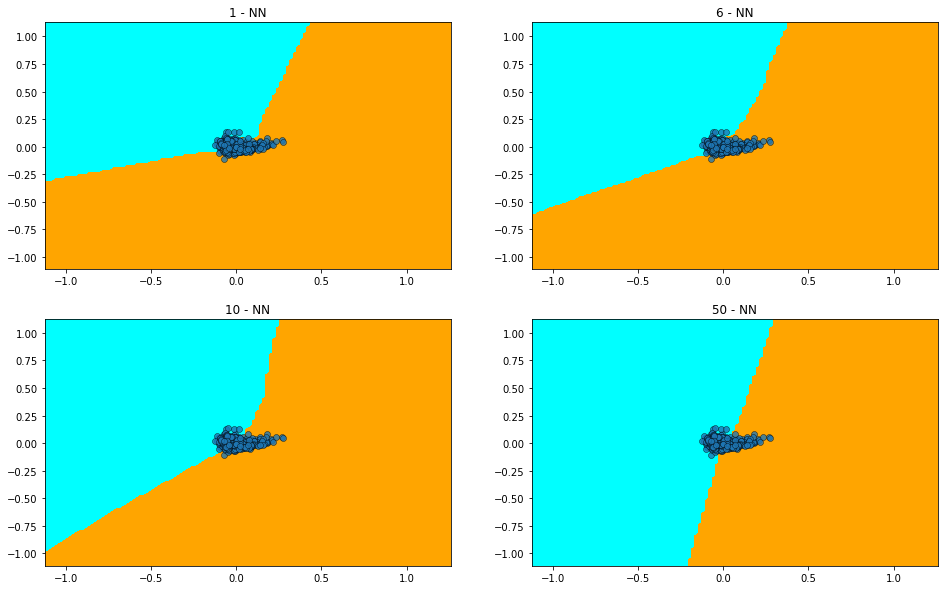

In [124]:
plot_decision_boundary(X, y, models_knn, 2, figsize = (16,10))

In [66]:
X[:, 1].max()

739.620918007658